# Trends.Earth Global Data Processing

This notebook submits SDG 15.3.1 indicator jobs to the Trends.Earth API using a grid-based approach.
Each 60-degree grid cell contains multiple 15-degree sub-cells that are submitted together.

In [1]:
import json
import logging
import os
import re
import time
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, List
from zoneinfo import ZoneInfo

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from shapely.geometry import Polygon

load_dotenv()

from trendsearth_api import (  # noqa: E402
    TrendsEarthAPIClient,
    convert_subcells_to_geojson,
    get_tiff_files,
    print_job_details,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs)03d %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# Configuration - API_URL will be overridden by environment variable if set
API_URL = os.getenv("API_BASE_URL", "https://api.trends.earth")
LOCAL_TZ = ZoneInfo("America/New_York")
NUM_DAYS = 7  # Number of days to look back for jobs
DOWNLOAD_DIR = Path("C:/Data/TrendsEarth_Global_Data_Tiles")

In [ ]:
class TrendsEarthGridAPIClient(TrendsEarthAPIClient):
    """
    Extended API client with grid cell-specific functionality for global data processing.

    This class inherits from TrendsEarthAPIClient and adds methods specific to handling
    grid cell jobs, including filtering, geometry conversion, and grid-specific filename generation.
    """

    def _generate_base_filename(self, task_name: str, job_id: str) -> str:
        """
        Override base filename generation for grid cell-specific naming.

        Args:
            task_name: Task name from job params
            job_id: Job ID

        Returns:
            Base filename string with grid cell components
        """
        components = {
            "grid_cell": "unknown",
            "year_range": "2000_2023",
            "productivity_mode": "unknown",
            "base_name": "TrendsEarth_SDG15.3.1_2000_2023",
        }

        # Extract grid cell number: 60deg_cell_X_with
        grid_match = re.search(r"60deg_cell_(\d+)_with", task_name)
        if grid_match:
            components["grid_cell"] = grid_match.group(1)

        # Extract productivity mode (last part after final underscore of subcells)
        mode_match = re.search(r"_subcells_(.+)$", task_name)
        if mode_match:
            components["productivity_mode"] = mode_match.group(1)

        # Extract year range if present in task name
        year_match = re.search(r"(\d{4})_(\d{4})", task_name)
        if year_match:
            components["year_range"] = f"{year_match.group(1)}_{year_match.group(2)}"
            components["base_name"] = (
                f"TrendsEarth_SDG15.3.1_{components['year_range']}"
            )

        return f"{components['base_name']}-60deg_cell-{components['grid_cell']}-{components['productivity_mode']}"

    def get_jobs_filtered_by_grid_cells(
        self, filter_name: str = None, days_back: int = 7, productivity_mode: str = None
    ) -> List[Dict]:
        """
        Get jobs from the API with grid cell filtering - returns only the most recent job for each grid cell.

        Args:
            filter_name: Filter jobs by this string in task name
            days_back: Number of days to look back (default: 7)
            productivity_mode: Filter by productivity mode ("TE", "FAO-WOCAT", "JRC"). REQUIRED - function fails if None.

        Returns:
            List of job dictionaries, filtered to most recent per grid cell and productivity mode

        Raises:
            ValueError: If productivity_mode is None or not specified
        """
        # REQUIRED: productivity_mode must be specified
        if productivity_mode is None:
            raise ValueError(
                "productivity_mode parameter is required and cannot be None. "
                "Specify one of: 'TE', 'FAO-WOCAT', 'JRC'"
            )

        if productivity_mode not in ["TE", "FAO-WOCAT", "JRC"]:
            raise ValueError(
                f"Invalid productivity_mode: '{productivity_mode}'. "
                "Valid options are: 'TE', 'FAO-WOCAT', 'JRC'"
            )

        # First get all jobs using the parent method
        all_jobs = self.get_jobs(filter_name=filter_name, days_back=days_back)

        # Apply grid cell filtering if the filter indicates grid cell jobs
        if filter_name and "60deg_cell_" in filter_name:
            # Dictionary to store the most recent job for each grid cell + productivity mode combination
            grid_cell_jobs = {}

            for job in all_jobs:
                task_name = job.get("params", {}).get("task_name", "")

                # Extract grid cell index from task name using regex
                # Pattern: sdg_indicator-60deg_cell_{index}_with_{count}_subcells_{productivity_mode}
                match = re.search(
                    r"60deg_cell_(\d+)_with_\d+_subcells_([A-Z-]+)", task_name
                )
                if match:
                    grid_index = int(match.group(1))
                    task_productivity_mode = match.group(2)

                    # STRICT: Only include jobs that match the specified productivity mode
                    if task_productivity_mode != productivity_mode:
                        continue

                    # Use grid_index + productivity_mode as the key to ensure separate tracking
                    key = (grid_index, task_productivity_mode)

                    # Parse start_date for comparison
                    try:
                        start_date_str = job.get("start_date", "")
                        if start_date_str:
                            # Handle timezone format
                            if start_date_str.endswith("Z"):
                                start_date_str = start_date_str.replace("Z", "+00:00")
                            start_date = datetime.fromisoformat(start_date_str)

                            # Keep only the most recent job for this grid cell + productivity mode combination
                            if key not in grid_cell_jobs:
                                grid_cell_jobs[key] = (job, start_date)
                            else:
                                existing_job, existing_date = grid_cell_jobs[key]
                                if start_date > existing_date:
                                    grid_cell_jobs[key] = (job, start_date)
                    except Exception as date_error:
                        print(
                            f"Warning: Could not parse date for job {job.get('id', 'unknown')}: {date_error}"
                        )
                        # If we can't parse the date, still include the job if no other job exists for this key
                        if key not in grid_cell_jobs:
                            grid_cell_jobs[key] = (
                                job,
                                datetime.min.replace(tzinfo=timezone.utc),
                            )

            # Extract just the jobs (not the dates) and sort by grid index
            filtered_jobs = [
                job_data[0]
                for key, job_data in sorted(
                    grid_cell_jobs.items(), key=lambda x: x[0][0]
                )
            ]

            print(
                f"Filtered to {len(filtered_jobs)} most recent jobs from {len(all_jobs)} total grid cell jobs for productivity mode '{productivity_mode}'"
            )
            return filtered_jobs

        return all_jobs


def load_job_parameters(productivity_mode="TE"):
    """
    Load SDG 15.3.1 job parameters from JSON files with configurable productivity data source.

    Args:
        productivity_mode: Productivity data source ("TE", "FAO-WOCAT", or "JRC")
                          - "TE": Trends.Earth productivity calculations (default)
                          - "FAO-WOCAT": FAO-WOCAT Land Productivity Dynamics
                          - "JRC": Joint Research Commission pre-calculated LPD

    Returns:
        Dictionary with job parameters, or None if failed
    """
    if productivity_mode not in ["TE", "FAO-WOCAT", "JRC"]:
        print(f"Invalid productivity mode: {productivity_mode}")
        print("Valid options: 'TE', 'FAO-WOCAT', 'JRC'")
        return None

    params = {}

    # Base parameter files (contain everything except productivity parameters)
    base_param_files = {
        "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline.json",
        "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1.json",
        "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2.json",
    }

    # Productivity parameter files based on chosen mode
    if productivity_mode == "FAO-WOCAT":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_fao_wocat.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_fao_wocat.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_fao_wocat.json",
        }
    elif productivity_mode == "JRC":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_jrc.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_jrc.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_jrc.json",
        }
    elif productivity_mode == "TE":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_te.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_te.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_te.json",
        }
    else:
        raise Exception("Unknown productivity approach")

    try:
        print(f"Loading parameters for productivity mode: {productivity_mode}")

        # Load baseline period
        with open(base_param_files["baseline_period"], "r") as f:
            baseline_params = json.load(f)

        # Override productivity parameters if needed
        if prod_param_files:
            try:
                with open(prod_param_files["baseline_period"], "r") as f:
                    prod_params = json.load(f)
                baseline_params["productivity"] = prod_params["productivity"]
                print(
                    f"Updated baseline with {productivity_mode} productivity parameters"
                )
            except FileNotFoundError:
                raise Exception(
                    f"{productivity_mode} baseline productivity file not found"
                )

        params["baseline_period"] = baseline_params

        # Load reporting periods
        params["status_periods"] = []
        for period in ["reporting_1", "reporting_2"]:
            with open(base_param_files[period], "r") as f:
                period_params = json.load(f)

            # Override productivity parameters if needed
            if prod_param_files:
                try:
                    with open(prod_param_files[period], "r") as f:
                        prod_params = json.load(f)
                    period_params["productivity"] = prod_params["productivity"]
                    print(
                        f"Updated {period} with {productivity_mode} productivity parameters"
                    )
                except FileNotFoundError:
                    raise Exception(
                        f"{productivity_mode} {period} productivity file not found"
                    )

            params["status_periods"].append(period_params)

        print(
            f"Job parameters loaded successfully with {productivity_mode} productivity"
        )
        print(f"Productivity mode: {params['baseline_period']['productivity']['mode']}")

        print(f"Reporting periods: {len(params['status_periods'])}")

        return params

    except FileNotFoundError as e:
        print(f"Parameter file not found: {e}")
        print(f"   Base files: {list(base_param_files.values())}")
        if prod_param_files:
            print(
                f"   {productivity_mode} productivity files: {list(prod_param_files.values())}"
            )
        return None
    except Exception as e:
        print(f"Error loading parameters: {e}")
        return None

## Authentication and API Setup

In [3]:
# Initialize the grid-specific API client
api_client = TrendsEarthGridAPIClient(API_URL)

# Authenticate with API using environment variables from .env file
if api_client.authenticate_from_env():
    print(f"API URL: {api_client.api_url}")
    print(f"Username: {os.getenv('API_USERNAME', 'Not set')}")
    print("Ready to submit and manage grid cell jobs.")
else:
    print("Authentication failed - check your environment variables")
    print("Please ensure your .env file contains:")
    print("- API_USERNAME=your_username")
    print("- API_PASSWORD=your_password")
    print("- API_BASE_URL=https://api.trends.earth (optional)")

Using API URL from environment: https://api.trends.earth
Authenticating with Trends.Earth API...
   Using email: trends.earth-prais-server@trends.earth


2025-10-27 08:27:05.136 INFO: Successfully authenticated with Trends.Earth API


Successfully authenticated with Trends.Earth API
API URL: https://api.trends.earth
Username: trends.earth-prais-server@trends.earth
Ready to submit and manage grid cell jobs.


## Create Global Grid System

Generate 60-degree (or 45 degree) main grid cells, each containing 16 sub-cells of 15 degrees each

In [4]:
# Define grid parameters
MAIN_CELL_SIZE = 60  # degrees - main grid cells
MAIN_CELL_SIZE = 45  # degrees - main grid cells
SUB_CELL_SIZE = 15  # degrees - sub-cells within each main grid cell
LON_MIN, LON_MAX = -180, 180
LAT_MIN, LAT_MAX = -90, 90


def create_global_grid():
    """Create global grid with main cells and sub-cells"""
    grid_cells = []
    grid_subcells = {}  # Dictionary to store sub-cells for each grid cell

    grid_index = 0

    for lon in range(LON_MIN, LON_MAX, MAIN_CELL_SIZE):
        for lat in range(LAT_MIN, LAT_MAX, MAIN_CELL_SIZE):
            # Create main 60-degree grid cell
            main_polygon = Polygon(
                [
                    (lon, lat),
                    (lon + MAIN_CELL_SIZE, lat),
                    (lon + MAIN_CELL_SIZE, lat + MAIN_CELL_SIZE),
                    (lon, lat + MAIN_CELL_SIZE),
                ]
            )

            grid_cells.append((main_polygon, f"{grid_index}"))

            # Create 15-degree sub-cells within this 60-degree cell
            sub_cells = []
            for sub_lon in range(lon, lon + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                for sub_lat in range(lat, lat + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                    sub_polygon = Polygon(
                        [
                            (sub_lon, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat + SUB_CELL_SIZE),
                            (sub_lon, sub_lat + SUB_CELL_SIZE),
                        ]
                    )
                    sub_cells.append(sub_polygon)

            grid_subcells[grid_index] = sub_cells
            grid_index += 1

    return grid_cells, grid_subcells


# Create the grid
grid_cells, grid_subcells = create_global_grid()

print(f"Created {len(grid_cells)} main grid cells of {MAIN_CELL_SIZE}¬∞ each")
print(
    f"Each main cell contains {len(grid_subcells[0])} sub-cells of {SUB_CELL_SIZE}¬∞ each"
)

Created 32 main grid cells of 45¬∞ each
Each main cell contains 9 sub-cells of 15¬∞ each


## Visualize Grid System

Red cells: 32 main grid cells (45¬∞ each)
Blue cells: 288 sub-cells (15¬∞ each)


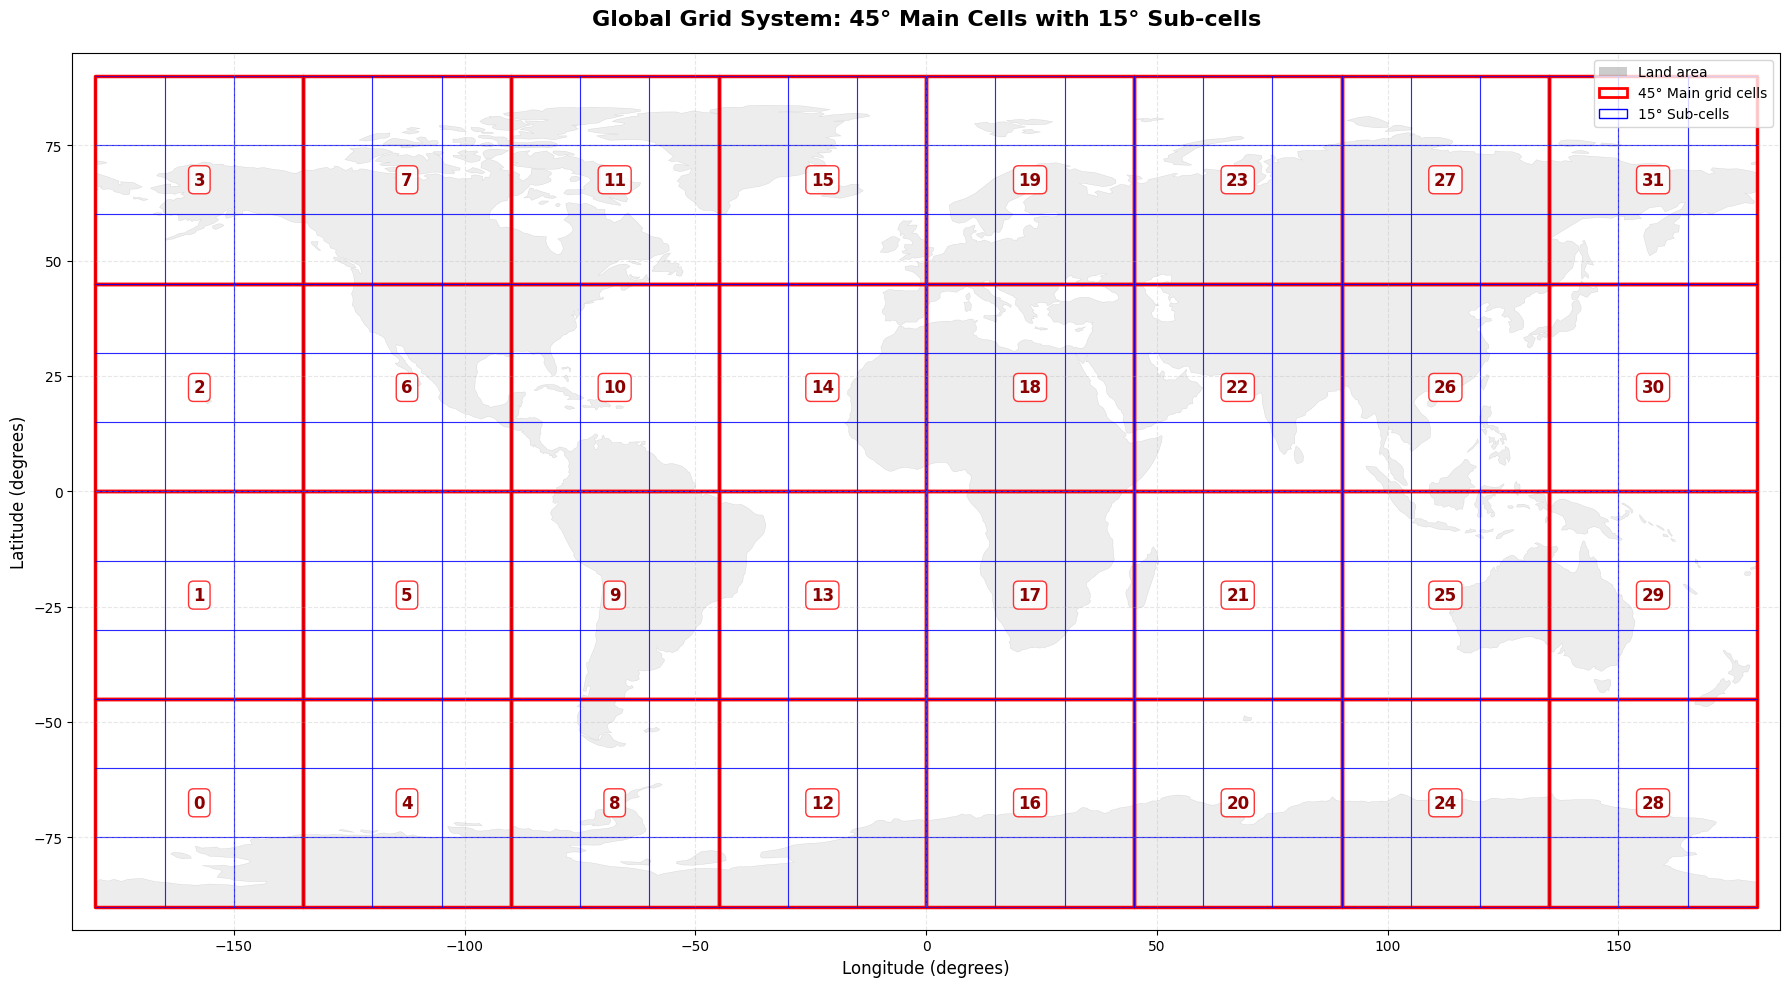

In [5]:
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Create GeoDataFrames for visualization
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=["geometry", "label"], crs="EPSG:4326")

# Create GeoDataFrame for sub-cells (for visualization)
sub_cell_data = []
for grid_index, sub_cells in grid_subcells.items():
    for i, sub_cell in enumerate(sub_cells):
        sub_cell_data.append((sub_cell, f"{grid_index}_{i}"))

sub_grid_gdf = gpd.GeoDataFrame(
    sub_cell_data, columns=["geometry", "label"], crs="EPSG:4326"
)

print(f"Red cells: {len(grid_gdf)} main grid cells ({MAIN_CELL_SIZE}¬∞ each)")
print(f"Blue cells: {len(sub_grid_gdf)} sub-cells ({SUB_CELL_SIZE}¬∞ each)")


# Get world boundaries using cartopy
def get_world_boundaries():
    """Get world boundaries from cartopy"""

    # Get land geometries from cartopy
    land = cfeature.LAND.geometries()

    # Convert to GeoDataFrame
    geoms = list(land)
    world = gpd.GeoDataFrame([{"geometry": geom} for geom in geoms], crs="EPSG:4326")
    return world


# Get world boundaries
world = get_world_boundaries()

# Plot the map
fig, ax = plt.subplots(figsize=(18, 10))

# Plot world boundaries from cartopy
world.plot(ax=ax, color="lightgray", edgecolor="darkgray", alpha=0.4, linewidth=0.3)

# Plot grid
grid_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2.5)
sub_grid_gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=0.8, alpha=0.6)

# Add enhanced labels to main grid cells
for idx, row in grid_gdf.iterrows():
    centroid = row.geometry.centroid

    # Add white background for better readability
    ax.text(
        centroid.x,
        centroid.y,
        row.label,
        fontsize=12,
        ha="center",
        va="center",
        color="darkred",
        weight="bold",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="red"
        ),
    )

# Enhance the plot appearance
ax.set_title(
    f"Global Grid System: {MAIN_CELL_SIZE}¬∞ Main Cells with {SUB_CELL_SIZE}¬∞ Sub-cells",
    fontsize=16,
    weight="bold",
    pad=20,
)
ax.set_xlabel("Longitude (degrees)", fontsize=12)
ax.set_ylabel("Latitude (degrees)", fontsize=12)

# Set axis limits and grid
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)
ax.grid(True, alpha=0.3, linestyle="--")

legend_elements = [
    Patch(facecolor="gray", alpha=0.4, label="Land area"),
    Patch(
        facecolor="none",
        edgecolor="red",
        linewidth=2,
        label=f"{MAIN_CELL_SIZE}¬∞ Main grid cells",
    ),
    Patch(
        facecolor="none",
        edgecolor="blue",
        linewidth=1,
        label=f"{SUB_CELL_SIZE}¬∞ Sub-cells",
    ),
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=10)

# Improve tick formatting
ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()

## Manage jobs

### Setup functions

In [6]:
def submit_sdg_indicator_job(api_client, geojsons, task_name, job_params):
    """
    Submit an SDG 15.3.1 indicator job to the API.

    Note: This is a simplified wrapper around api_client.submit_job() with
    SDG-specific parameter formatting. The core submission logic is handled
    by the shared TrendsEarthAPIClient.

    Args:
        api_client: TrendsEarthAPIClient instance
        geojsons: List of GeoJSON geometries for the areas of interest
        task_name: Name for the submitted task
        job_params: Job parameters including baseline_period and status_periods

    Returns:
        Job ID if successful, False otherwise
    """
    if not api_client.access_token or not job_params:
        print("Missing authentication token or job parameters")
        return False

    # Prepare job parameters specific to SDG indicator jobs
    params = {
        "geojsons": geojsons,
        "baseline_period": job_params["baseline_period"],
        "status_periods": job_params["status_periods"],
        "script": job_params["baseline_period"]["script"],
        "task_name": task_name,
        "task_notes": job_params["baseline_period"].get("task_notes", ""),
        "filetype": job_params["baseline_period"].get("filetype", "tif"),
        "crosses_180th": job_params["baseline_period"].get("crosses_180th", False),
        "crs": job_params["baseline_period"].get("crs", "EPSG:4326"),
    }

    # Submit using the generic submit_job method from TrendsEarthAPIClient
    job_id = api_client.submit_job("sdg-15-3-1-indicator-2-1-20", params)
    return job_id


print("SDG indicator job submission function ready (using shared API client)")

SDG indicator job submission function ready (using shared API client)


### Submit Jobs for Grid Cells

Submit jobs for selected grid cells. Each job contains all 15-degree sub-cells within a 60-degree main cell.

In [ ]:
# Select which grid cells to process
grid_indices = list(range(0, len(grid_cells)))
grid_indices = [4, 10, 13]
grid_indices = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

PRODUCTIVITY_MODE = "TE"
# PRODUCTIVITY_MODE = "JRC"
PRODUCTIVITY_MODE = "FAO-WOCAT"
SUBMIT_JOBS = True  # Set to False to just show what would be submitted
PAUSE_BETWEEN_JOBS = True  # Add random delay between submissions

submitted_jobs = []

job_params = load_job_parameters(PRODUCTIVITY_MODE)

if api_client.access_token and job_params:
    print(f"Starting job submission for {len(grid_indices)} grid cells...")

    for i, grid_index in enumerate(grid_indices):
        # Get the 15-degree sub-cells for this 60-degree grid cell
        sub_cells = grid_subcells[grid_index]

        # Convert to geojson format
        sub_cell_geojsons = convert_subcells_to_geojson(sub_cells)

        # Create task name
        task_name = f"sdg_indicator-60deg_cell_{grid_index}_with_{len(sub_cell_geojsons)}_subcells_{PRODUCTIVITY_MODE}"

        print(f"\nJob {i + 1}/{len(grid_indices)}: Grid cell {grid_index}")
        print(f"   Task name: {task_name}")
        print(f"   Sub-cells: {len(sub_cell_geojsons)} √ó {SUB_CELL_SIZE}¬∞")
        print(f"   Productivity mode: {PRODUCTIVITY_MODE}")

        if SUBMIT_JOBS:
            # Submit the job using the local function
            job_id = submit_sdg_indicator_job(
                api_client, sub_cell_geojsons, task_name, job_params
            )

            if job_id:
                submitted_jobs.append(
                    {
                        "grid_index": grid_index,
                        "task_name": task_name,
                        "producivity_mode": PRODUCTIVITY_MODE,
                        "job_id": job_id,
                        "sub_cells_count": len(sub_cell_geojsons),
                    }
                )

            # Add delay between jobs to avoid overwhelming the server
            if PAUSE_BETWEEN_JOBS and i < len(grid_indices) - 1:
                sleep_time = np.abs(np.random.normal(30, 15))  # 30¬±15 seconds
                print(f"   ‚è±Waiting {sleep_time:.0f} seconds before next submission...")
                time.sleep(sleep_time)
        else:
            print(
                f"   ‚Ñπ[DRY RUN] Would submit job with {len(sub_cell_geojsons)} sub-cells"
            )

    if SUBMIT_JOBS:
        print("\nJob submission complete!")
        print(f"Successfully submitted: {len(submitted_jobs)}/{len(grid_indices)} jobs")

        if submitted_jobs:
            print("\nüìã Submitted job summary:")
            for job in submitted_jobs:
                print(
                    f"   Grid {job['grid_index']}: {job['job_id']} ({job['sub_cells_count']} sub-cells)"
                )
    else:
        print("\nDry run complete - no jobs were actually submitted")

else:
    print("Cannot submit jobs: missing authentication token or job parameters")

### Check Job Status

Monitor the status of submitted jobs

In [7]:
# Get grid cell jobs
print("Fetching grid cell jobs...")

# PRODUCTIVITY_MODE = "TE"
# PRODUCTIVITY_MODE = "JRC"
PRODUCTIVITY_MODE = "FAO-WOCAT"

# Get our specific jobs (grid cell jobs) using the grid-specific filter
# Now filters by productivity mode as well
grid_jobs = api_client.get_jobs_filtered_by_grid_cells(
    filter_name="60deg_cell_", days_back=NUM_DAYS, productivity_mode=PRODUCTIVITY_MODE
)

print(
    f"Found {len(grid_jobs)} grid cell jobs for productivity mode: {PRODUCTIVITY_MODE}"
)

# Print grid cell job details using shared functions
if grid_jobs:
    print_job_details(grid_jobs, max_jobs=20, local_tz=LOCAL_TZ)

    # Store for download later
    jobs = grid_jobs
else:
    print(f"üì≠ No grid cell jobs found for productivity mode: {PRODUCTIVITY_MODE}")
    jobs = []

print("\nJob status check complete")

Fetching grid cell jobs...
Filtered to 18 most recent jobs from 55 total grid cell jobs for productivity mode 'FAO-WOCAT'
Found 18 grid cell jobs for productivity mode: FAO-WOCAT

Job Details (showing up to 20):
    1. sdg_indicator-60deg_cell_0_wit | FINISHED   | Oct 26 - 02:30 PM ‚Üí Oct 26 - 06:13 PM
    2. sdg_indicator-60deg_cell_1_wit | FINISHED   | Oct 26 - 02:31 PM ‚Üí Oct 26 - 07:31 PM
    3. sdg_indicator-60deg_cell_2_wit | FINISHED   | Oct 26 - 02:31 PM ‚Üí Oct 26 - 08:13 PM
    4. sdg_indicator-60deg_cell_3_wit | FINISHED   | Oct 26 - 02:32 PM ‚Üí Oct 26 - 09:13 PM
    5. sdg_indicator-60deg_cell_4_wit | FINISHED   | Oct 26 - 02:33 PM ‚Üí Oct 26 - 09:52 PM
    6. sdg_indicator-60deg_cell_5_wit | FINISHED   | Oct 26 - 02:33 PM ‚Üí Oct 26 - 11:15 PM
    7. sdg_indicator-60deg_cell_6_wit | FINISHED   | Oct 26 - 02:33 PM ‚Üí Oct 26 - 10:20 PM
    8. sdg_indicator-60deg_cell_7_wit | FINISHED   | Oct 26 - 02:33 PM ‚Üí Oct 27 - 12:29 AM
    9. sdg_indicator-60deg_cell_8_wit | FINI

### Download Jobs

In [ ]:
# Create productivity mode specific download directory
productivity_download_dir = DOWNLOAD_DIR / PRODUCTIVITY_MODE
if not productivity_download_dir.exists():
    productivity_download_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {productivity_download_dir}")
else:
    print(f"Using directory: {productivity_download_dir}")

# Get finished jobs that match the current productivity mode
if "jobs" in locals() and jobs:
    # Filter jobs to only include those matching the current PRODUCTIVITY_MODE
    finished_jobs = []
    for job in jobs:
        if job.get("status") == "FINISHED":
            task_name = job.get("params", {}).get("task_name", "")
            if task_name.endswith(f"_subcells_{PRODUCTIVITY_MODE}"):
                finished_jobs.append(job)

    print(f"Found {len(finished_jobs)} finished jobs for {PRODUCTIVITY_MODE}")

    if finished_jobs:
        downloaded_files = []
        tiff_files = []

        for i, job in enumerate(finished_jobs):
            task_name = job.get("params", {}).get("task_name", "unknown")
            job_id = job.get("id", "unknown")

            print(f"Job {i + 1}/{len(finished_jobs)}: {task_name}")

            try:
                # Download directly into productivity mode directory (all jobs in same folder)
                # The API client handles metadata saving with standardized naming via the subclass
                job_download_dir = api_client.download_job(
                    job, productivity_download_dir
                )

                # If API client returns None, use the productivity mode directory directly
                if job_download_dir is None:
                    print("  API download failed")

                elif job_download_dir and job_download_dir.exists():
                    print(f"  Using directory: {job_download_dir}")

                    # Get downloaded files from the directory
                    job_downloaded_files = list(job_download_dir.glob("*"))
                    downloaded_files.extend(job_downloaded_files)

                    # Add to TIFF files list
                    _, downloaded_tiffs = get_tiff_files(job_downloaded_files)
                    if downloaded_tiffs:
                        tiff_files.extend(downloaded_tiffs)
                        print(f"  Found {len(downloaded_tiffs)} TIFF files")
                    else:
                        print("  No TIFF files found yet")

                else:
                    print("  Failed to access download directory")

            except Exception as download_error:
                print(f"  Download error: {str(download_error)}")

        print(
            f"\nDownload complete: {len(downloaded_files)} files, {len(tiff_files)} TIFF files"
        )
        print(f"Location: {productivity_download_dir}")

        if tiff_files:
            print("\nTIFF files:")
            for tiff in tiff_files[:5]:
                print(f"  {tiff.name}")
            if len(tiff_files) > 5:
                print(f"  ... and {len(tiff_files) - 5} more")

    else:
        print(f"No finished jobs available for {PRODUCTIVITY_MODE}")
else:
    print("No jobs available - run job status check first")

Created directory: C:\Data\TrendsEarth_Global_Data_Tiles\FAO-WOCAT
Found 18 finished jobs for FAO-WOCAT
Job 1/18: sdg_indicator-60deg_cell_0_with_16_subcells_FAO-WOCAT
Found 1 raster datasets
Processing raster: Int16
  Found 16 tiles
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/f8e41758-e4af-4dd0-8784-30a7133c11d0_sdg_indicator_Int16_1.tif?generation=1761498015195043&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-0-FAO-WOCAT-Int16_1.tif
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/f8e41758-e4af-4dd0-8784-30a7133c11d0_sdg_indicator_Int16_2.tif?generation=1761498524379908&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-0-FAO-WOCAT-Int16_1.tif
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/f8e41758-e4af-4dd0-8784-30a7133c11d0_sdg_indicator_Int16_2.tif?generation=1761498524379908&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-0-FAO-WOCAT-Int16_2

## Create mosaic

### Setup functions

In [9]:
import subprocess
from pathlib import Path

# Add OSGeo4W GDAL tools to PATH
osgeo_bin = r"C:\OSGeo4W\bin"
if Path(osgeo_bin).exists():
    current_path = os.environ.get("PATH", "")
    if osgeo_bin not in current_path:
        os.environ["PATH"] = f"{osgeo_bin};{current_path}"
        print(f"Added {osgeo_bin} to PATH")
    else:
        print(f"{osgeo_bin} already in PATH")
else:
    print(f" Warning: {osgeo_bin} not found. Please install OSGeo4W or GDAL")

# Verify GDAL tools are available
try:
    result = subprocess.run(
        ["gdalbuildvrt", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("gdalbuildvrt is available")
    else:
        print("gdalbuildvrt failed")
except FileNotFoundError:
    print("gdalbuildvrt not found in PATH")
except Exception as e:
    print(f"Error checking gdalbuildvrt: {e}")

try:
    result = subprocess.run(
        ["gdal_translate", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("gdal_translate is available")
    else:
        print("gdal_translate failed")
except FileNotFoundError:
    print("gdal_translate not found in PATH")
except Exception as e:
    print(f"Error checking gdal_translate: {e}")

print("\nüîß GDAL PATH configuration complete")

Added C:\OSGeo4W\bin to PATH
gdalbuildvrt is available
gdal_translate is available

üîß GDAL PATH configuration complete


In [ ]:
import xml.etree.ElementTree as ET


def add_band_descriptions_to_vrt(vrt_path, productivity_mode):
    """
    Add band description metadata to VRT file

    Args:
        vrt_path: Path to the VRT file
        productivity_mode: Productivity mode ("TE", "FAO-WOCAT", "JRC")
    """
    # Define productivity method text based on mode
    prod_method = {"TE": "Trends.Earth", "FAO-WOCAT": "FAO-WOCAT", "JRC": "JRC"}.get(
        productivity_mode
    )

    # Band descriptions
    band_descriptions = [
        "SDG Indicator 15.3.1 for baseline (2000-2015)",
        f"Land Productivity Dynamics (using {prod_method}) for 2001 - 2015",
        "Land cover degradation for 2000 - 2015",
        "Soil organic carbon degradation for 2000 - 2015",
        "SDG Indicator 15.3.1 for 2004-2019",
        f"Land Productivity Dynamics (using {prod_method}) for 2004 - 2019",
        "Land cover degradation for 2015 - 2019",
        "Soil organic carbon degradation for 2015 - 2019",
        "SDG Indicator 15.3.1 status in 2019 (compared to 2000-2015 baseline)",
        "SDG Indicator 15.3.1 for 2008-2023",
        f"Land Productivity Dynamics (using {prod_method}) for 2008-2023",
        "Land cover degradation for 2015 - 2023",
        "Soil organic carbon degradation for 2015 - 2023",
        "SDG Indicator 15.3.1 status in 2023 (compared to 2000-2015 baseline)",
    ]

    try:
        # Parse VRT file
        tree = ET.parse(vrt_path)
        root = tree.getroot()

        # Find all VRTRasterBand elements
        bands = root.findall(".//VRTRasterBand")

        if len(bands) != len(band_descriptions):
            print(
                f"‚ö†Ô∏è  Warning: Found {len(bands)} bands but have {len(band_descriptions)} descriptions"
            )

        # Add description to each band
        for i, band in enumerate(bands):
            if i < len(band_descriptions):
                # Remove existing Description element if present
                for desc in band.findall("Description"):
                    band.remove(desc)

                # Add new Description element
                desc_elem = ET.SubElement(band, "Description")
                desc_elem.text = band_descriptions[i]

        # Write modified VRT
        tree.write(vrt_path, encoding="utf-8", xml_declaration=True)
        print(f"‚úÖ Added band descriptions to VRT ({len(bands)} bands)")

    except Exception as e:
        print(f"‚ùå Error adding band descriptions: {e}")


print("‚úÖ Band description function defined")

In [ ]:
import multiprocessing
import subprocess
from pathlib import Path

# Get all tiffs for the chosen productivity mode
tiff_pattern = f"TrendsEarth_SDG15.3.1_*-{PRODUCTIVITY_MODE}-*.tif"
tiff_files = sorted(productivity_download_dir.glob(tiff_pattern))
print(f"Found {len(tiff_files)} TIFFs for {PRODUCTIVITY_MODE}")

if not tiff_files:
    raise ValueError(f"No TIFF files found matching pattern: {tiff_pattern}")

# Create output mosaic filename
output_mosaic = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}.tif"
)
vrt_file = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}_temp_mosaic.vrt"
)
file_list = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}_tiff_files.txt"
)

# Get optimal settings
cpu_count = multiprocessing.cpu_count()
warp_threads = max(1, cpu_count - 1)
cache_mb = 4096

print(f"Using {warp_threads} threads, {cache_mb}MB cache")

# Write file list
with open(file_list, "w") as f:
    for tiff in tiff_files:
        f.write(f"{tiff}\n")

# Build VRT using file list
gdalbuildvrt = str(Path(osgeo_bin) / "gdalbuildvrt.exe")
print("Building VRT...")
subprocess.run(
    [gdalbuildvrt, "-input_file_list", str(file_list), str(vrt_file)], check=True
)

# Add band descriptions to VRT
add_band_descriptions_to_vrt(vrt_file, PRODUCTIVITY_MODE)

# Create COG with optimizations
gdal_translate = str(Path(osgeo_bin) / "gdal_translate.exe")
print("Creating COG mosaic...")
subprocess.run(
    [
        gdal_translate,
        "-of",
        "COG",
        "-co",
        "COMPRESS=LZW",
        "-co",
        "PREDICTOR=2",
        "-co",
        "NUM_THREADS=ALL_CPUS",
        "-co",
        "BIGTIFF=YES",
        "--config",
        "GDAL_CACHEMAX",
        str(cache_mb),
        "--config",
        "GDAL_NUM_THREADS",
        str(warp_threads),
        str(vrt_file),
        str(output_mosaic),
    ],
    check=True,
)

# Cleanup
vrt_file.unlink()
file_list.unlink()
print(f"‚úÖ Mosaic created: {output_mosaic}")

Found 288 TIFFs for FAO-WOCAT
Using 19 threads, 4096MB cache
Building VRT...
Creating COG mosaic...


### Validate tiles

In [10]:
# Fix GDAL environment and validate files before mosaic creation
import os
import subprocess
from pathlib import Path


def setup_gdal_environment():
    """Setup GDAL environment variables and validate files"""
    print("üîß Setting up GDAL environment...")

    # Set GDAL_DATA environment variable
    osgeo_data = r"C:\OSGeo4W\share\gdal"
    if Path(osgeo_data).exists():
        os.environ["GDAL_DATA"] = osgeo_data
        print(f"‚úÖ Set GDAL_DATA: {osgeo_data}")
    else:
        # Try alternative locations
        alt_paths = [
            r"C:\OSGeo4W64\share\gdal",
            r"C:\Program Files\GDAL\gdal-data",
            r"C:\tools\gdal\gdal-data",
        ]
        for alt_path in alt_paths:
            if Path(alt_path).exists():
                os.environ["GDAL_DATA"] = alt_path
                print(f"‚úÖ Set GDAL_DATA: {alt_path}")
                break
        else:
            print("‚ö†Ô∏è  Warning: Could not find GDAL_DATA directory")

    # Set other GDAL environment variables
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["GDAL_HTTP_TIMEOUT"] = "300"
    os.environ["GDAL_HTTP_CONNECTTIMEOUT"] = "60"
    print("‚úÖ Set GDAL performance variables")


def validate_single_tiff_file(tiff_file_path, timeout=30):
    """
    Validate a single TIFF file using GDAL

    Args:
        tiff_file_path: Path to the TIFF file to validate
        timeout: Timeout in seconds for validation (default: 30)

    Returns:
        tuple: (is_valid: bool, error_message: str or None)
    """
    tiff_file = Path(tiff_file_path)

    if not tiff_file.exists():
        return False, f"File does not exist: {tiff_file}"

    if not tiff_file.is_file():
        return False, f"Path is not a file: {tiff_file}"

    try:
        # Strict validation using gdalinfo with checksum
        result = subprocess.run(
            ["gdalinfo", "-checksum", str(tiff_file)],
            capture_output=True,
            text=True,
            timeout=timeout,
        )

        if result.returncode != 0:
            return (
                False,
                f"gdalinfo failed with return code {result.returncode}: {result.stderr}",
            )

        # Check for any error messages in output
        if "ERROR" in result.stderr:
            return False, f"GDAL stderr error: {result.stderr.strip()}"

        if "ERROR" in result.stdout:
            return False, f"GDAL stdout error: {result.stdout.strip()}"

        # Check if file has valid size information
        if "Size is" not in result.stdout:
            return False, "Missing raster size information in gdalinfo output"

        # Check for coordinate system
        if (
            "Coordinate System is" not in result.stdout
            and "GEOGCS" not in result.stdout
            and "PROJCS" not in result.stdout
        ):
            return False, "Missing or invalid coordinate system information"

        # File passed all validations
        return True, None

    except subprocess.TimeoutExpired:
        return False, f"Validation timeout after {timeout} seconds"

    except Exception as e:
        return False, f"Validation exception: {str(e)}"


def validate_input_files(
    input_dir, file_pattern="TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif"
):
    """Validate ALL input TIFF files - CRITICAL: All files must pass validation"""
    print("\nüîç Validating ALL input TIFF files (STRICT MODE)...")

    input_path = Path(input_dir)
    tiff_files = list(input_path.glob(file_pattern))

    if not tiff_files:
        raise ValueError(
            f"‚ùå CRITICAL ERROR: No files found matching pattern: {file_pattern}"
        )

    print(f"üìã Found {len(tiff_files)} files - ALL must validate successfully")
    print("‚ö†Ô∏è  STRICT MODE: If ANY file fails validation, the entire process will stop")

    failed_files = []

    for i, tiff_file in enumerate(tiff_files):
        if (
            i % 50 == 0 or i == len(tiff_files) - 1
        ):  # Progress every 50 files and at the end
            print(f"   Validating file {i + 1}/{len(tiff_files)}...")

        # Use the single file validation function
        is_valid, error_message = validate_single_tiff_file(tiff_file)

        if not is_valid:
            failed_files.append((tiff_file, error_message))
            print(f"   ‚ùå FAILED: {tiff_file.name} - {error_message}")
        else:
            # Show success every 100 files to avoid too much output
            if i % 100 == 0:
                print(f"   ‚úÖ OK: {tiff_file.name}")

    # CRITICAL: Check if ALL files passed validation
    valid_count = len(tiff_files) - len(failed_files)

    print("\nüìä Validation Results:")
    print(f"   ‚úÖ Valid files: {valid_count}")
    print(f"   ‚ùå Failed files: {len(failed_files)}")

    if failed_files:
        print(f"\n‚ùå CRITICAL ERROR: {len(failed_files)} files FAILED validation")
        print("üö´ Cannot proceed with mosaic creation - ALL files must be valid")
        print("\nFailed files:")
        for failed_file, reason in failed_files:
            print(f"   ‚ùå {failed_file.name}: {reason}")

        # Raise exception to stop the process
        raise RuntimeError(
            f"CRITICAL: {len(failed_files)} out of {len(tiff_files)} files failed validation. "
            f"All files must be valid for complete mosaic. Please check and fix the corrupted files."
        )

    print(f"‚úÖ SUCCESS: ALL {len(tiff_files)} files passed strict validation")
    print("üéØ Proceeding with complete mosaic creation using all files")

    return tiff_files

In [11]:
# Setup GDAL environment
setup_gdal_environment()

# Validate ALL input files (strict mode - all must pass)
try:
    all_files = validate_input_files(DOWNLOAD_DIR)
    print(f"\nüéØ Ready for mosaic creation with ALL {len(all_files)} validated files")
except (ValueError, RuntimeError) as e:
    print(f"\nüö´ VALIDATION FAILED: {e}")
    print("‚ùå Cannot proceed with mosaic creation")
    print("üí° Please fix the corrupted/missing files and run validation again")
    raise  # Re-raise to stop execution

üîß Setting up GDAL environment...
‚ö†Ô∏è  Warning: Could not find GDAL_DATA directory
‚úÖ Set GDAL performance variables

üîç Validating ALL input TIFF files (STRICT MODE)...

üö´ VALIDATION FAILED: ‚ùå CRITICAL ERROR: No files found matching pattern: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif
‚ùå Cannot proceed with mosaic creation
üí° Please fix the corrupted/missing files and run validation again


ValueError: ‚ùå CRITICAL ERROR: No files found matching pattern: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif

## Upload final mosaic and tiles to Google Cloud Storage

In [ ]:
import os
import subprocess
from pathlib import Path

# Google Cloud Storage and Earth Engine imports
try:
    import ee
    from google.cloud import storage

    print("‚úÖ Google Cloud and Earth Engine libraries available")
except ImportError as e:
    print(f"‚ö†Ô∏è  Warning: Missing libraries: {e}")
    print("üì¶ Install with: pip install google-cloud-storage earthengine-api")


def upload_to_gcs(
    local_file_path,
    bucket_name,
    gcs_blob_path=None,
    chunk_size=1024 * 1024 * 8,  # 8MB chunks
    timeout=3600,  # 1 hour timeout
):
    """
    Upload a file to Google Cloud Storage with progress tracking

    Args:
        local_file_path: Path to local file to upload
        bucket_name: GCS bucket name
        gcs_blob_path: Path in GCS bucket (if None, uses filename)
        chunk_size: Upload chunk size in bytes (default: 8MB)
        timeout: Upload timeout in seconds (default: 1 hour)

    Returns:
        str: GCS URI (gs://bucket/path) if successful, None if failed
    """
    try:
        # Initialize GCS client
        client = storage.Client()
        bucket = client.bucket(bucket_name)

        local_file = Path(local_file_path)
        if not local_file.exists():
            print(f"‚ùå Local file not found: {local_file}")
            return None

        # Use filename if no blob path specified
        if gcs_blob_path is None:
            gcs_blob_path = local_file.name

        blob = bucket.blob(gcs_blob_path)

        # Check if file already exists
        if blob.exists():
            print(f"‚è≠Ô∏è  File already exists in GCS: gs://{bucket_name}/{gcs_blob_path}")
            return f"gs://{bucket_name}/{gcs_blob_path}"

        # Get file size for progress tracking
        file_size = local_file.stat().st_size
        file_size_mb = file_size / (1024 * 1024)

        print(f"üì§ Uploading {local_file.name} ({file_size_mb:.1f} MB) to GCS...")
        print(f"   üìç Destination: gs://{bucket_name}/{gcs_blob_path}")

        # Upload with timeout and chunking
        blob.chunk_size = chunk_size

        with open(local_file, "rb") as file_obj:
            blob.upload_from_file(file_obj, timeout=timeout)

        print(f"‚úÖ Upload successful: gs://{bucket_name}/{gcs_blob_path}")
        return f"gs://{bucket_name}/{gcs_blob_path}"

    except Exception as e:
        print(f"‚ùå GCS upload failed: {e}")
        return None


def upload_all_tiles_to_gcs(
    tiles_dir_or_files,
    mosaic_file,
    bucket_name,
    tiles_folder="tiles",
    mosaic_folder="global-mosaics",
):
    """
    Upload all tiles and mosaic to Google Cloud Storage

    Args:
        tiles_dir_or_files: Directory path or list of tile files to upload
        mosaic_file: Path to the global mosaic file
        bucket_name: GCS bucket name
        tiles_folder: Folder in GCS for tiles (default: "tiles")
        mosaic_folder: Folder in GCS for mosaic (default: "global-mosaics")

    Returns:
        dict: Upload results with tile_gcs_uris, mosaic_gcs_uri, failed_tiles
    """
    print("üì§ Starting bulk upload to Google Cloud Storage...")
    print("=" * 60)

    results = {
        "tile_gcs_uris": [],
        "mosaic_gcs_uri": None,
        "failed_tiles": [],
        "success": False,
    }

    # Handle tiles input (can be directory path or list of files)
    if isinstance(tiles_dir_or_files, (str, Path)):
        # Directory path provided
        tiles_dir = Path(tiles_dir_or_files)
        if not tiles_dir.exists():
            print(f"‚ùå Tiles directory not found: {tiles_dir}")
            return results
        tile_files = list(tiles_dir.glob("*.tif"))
    else:
        # List of files provided
        tile_files = tiles_dir_or_files

    if not tile_files:
        print("‚ùå No tile files found")
        return results

    print(f"üìã Found {len(tile_files)} tiles to upload")

    # Step 1: Upload mosaic file
    if mosaic_file and Path(mosaic_file).exists():
        print("\nüì§ Step 1: Uploading global mosaic...")
        mosaic_gcs_path = f"{mosaic_folder}/{Path(mosaic_file).name}"
        mosaic_gcs_uri = upload_to_gcs(
            local_file_path=mosaic_file,
            bucket_name=bucket_name,
            gcs_blob_path=mosaic_gcs_path,
        )

        if mosaic_gcs_uri:
            results["mosaic_gcs_uri"] = mosaic_gcs_uri
            print("‚úÖ Mosaic uploaded successfully")
        else:
            print("‚ùå Failed to upload mosaic")
    else:
        print("‚è≠Ô∏è  Skipping mosaic upload (file not found or not provided)")

    # Step 2: Upload all tile files
    print(f"\nüì§ Step 2: Uploading {len(tile_files)} tiles...")

    for i, tile_file in enumerate(tile_files):
        if i % 10 == 0 or i == len(tile_files) - 1:  # Progress every 10 files
            print(f"   üìä Progress: {i + 1}/{len(tile_files)} tiles")

        tile_gcs_path = f"{tiles_folder}/{tile_file.name}"
        tile_gcs_uri = upload_to_gcs(
            local_file_path=tile_file,
            bucket_name=bucket_name,
            gcs_blob_path=tile_gcs_path,
        )

        if tile_gcs_uri:
            results["tile_gcs_uris"].append(tile_gcs_uri)
        else:
            results["failed_tiles"].append(tile_file.name)

    # Summary
    print("\nüìä GCS Upload Results:")
    print(f"   ‚úÖ Tiles uploaded: {len(results['tile_gcs_uris'])}")
    print(f"   ‚ùå Failed tiles: {len(results['failed_tiles'])}")
    print(f"   üì§ Mosaic uploaded: {'‚úÖ' if results['mosaic_gcs_uri'] else '‚ùå'}")

    if results["failed_tiles"]:
        print(f"   Failed files: {results['failed_tiles'][:5]}...")  # Show first 5

    results["success"] = len(results["failed_tiles"]) == 0

    return results


def import_tiles_to_gee_from_gcs(
    gcs_uris,
    asset_id,
    asset_title="SDG 15.3.1 Land Degradation Indicator",
    pyramiding_policy="MEAN",
    wait_for_completion=False,
    max_wait_minutes=30,
):
    """
    Start GEE import tasks for tiles already uploaded to GCS

    Args:
        gcs_uris: List of GCS URIs (gs://bucket/path) for the tiles
        asset_id: Full GEE asset ID (users/username/folder/asset_name)
        asset_title: Title for the GEE asset
        pyramiding_policy: GEE pyramiding policy (MEAN, MODE, MIN, MAX, SAMPLE)
        wait_for_completion: Whether to wait for import completion
        max_wait_minutes: Maximum wait time in minutes

    Returns:
        dict: Import results with task_id, asset_id, success status
    """
    print("üåç Starting Google Earth Engine import from GCS...")
    print("=" * 60)

    results = {
        "task_id": None,
        "asset_id": None,
        "success": False,
        "status": "NOT_STARTED",
    }

    try:
        # Initialize Earth Engine
        try:
            ee.Initialize()
            print("‚úÖ Earth Engine initialized")
        except Exception as init_error:
            print(f"‚ùå Earth Engine initialization failed: {init_error}")
            print("üí° Try running: earthengine authenticate")
            return results

        if not gcs_uris:
            print("‚ùå No GCS URIs provided")
            return results

        print(f"üìã Importing {len(gcs_uris)} tiles to GEE asset: {asset_id}")

        # Use earthengine command-line tool for better control
        print("üì° Submitting GEE import request using earthengine CLI...")

        # Create a temporary manifest file
        import json
        import tempfile

        manifest = {
            "name": asset_id,
            "tilesets": [{"sources": [{"uris": gcs_uris}]}],
            "bands": [
                {
                    "id": "sdg_15_3_1_indicator",
                    "tileset_band_index": 0,
                    "tileset_id": 0,
                    "pyramiding_policy": pyramiding_policy,
                }
            ],
            "properties": {
                "title": asset_title,
                "description": "Global SDG 15.3.1 land degradation indicator from Trends.Earth",
                "source": "Trends.Earth Global Processing",
                "created": datetime.now().isoformat(),
                "tiles_count": len(gcs_uris),
            },
        }

        # Write manifest to temporary file
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False) as f:
            json.dump(manifest, f, indent=2)
            manifest_path = f.name

        try:
            # Submit upload using earthengine CLI
            cmd = [
                "earthengine",
                "upload",
                "image",
                "--asset_id",
                asset_id,
                "--manifest",
                manifest_path,
            ]

            print(f"üîß Running: {' '.join(cmd)}")
            result = subprocess.run(
                cmd,
                capture_output=True,
                text=True,
                timeout=300,  # 5 minutes timeout
            )

            if result.returncode == 0:
                # Extract task ID from output
                output_lines = result.stdout.strip().split("\n")
                task_id = None
                for line in output_lines:
                    if "Started upload task with ID" in line:
                        task_id = line.split("ID")[-1].strip().strip(":")
                        break

                results["task_id"] = task_id
                results["asset_id"] = asset_id
                results["status"] = "RUNNING"
                results["success"] = True

                print("‚úÖ GEE import task started successfully!")
                print(f"üìã Task ID: {task_id}")
                print(f"üåç Asset ID: {asset_id}")

                if wait_for_completion and task_id:
                    print(
                        f"‚è≥ Waiting for completion (max {max_wait_minutes} minutes)..."
                    )

                    import time

                    start_time = time.time()

                    while True:
                        # Check task status
                        status_cmd = ["earthengine", "task", "info", task_id]
                        status_result = subprocess.run(
                            status_cmd, capture_output=True, text=True, timeout=30
                        )

                        if status_result.returncode == 0:
                            status_output = status_result.stdout

                            if "State: COMPLETED" in status_output:
                                print("üéâ GEE import completed successfully!")
                                results["status"] = "COMPLETED"
                                break
                            elif "State: FAILED" in status_output:
                                print("‚ùå GEE import failed")
                                results["status"] = "FAILED"
                                results["success"] = False
                                break
                            else:
                                elapsed_minutes = (time.time() - start_time) / 60
                                print(
                                    f"   üìä Status: RUNNING (elapsed: {elapsed_minutes:.1f} min)"
                                )

                                if elapsed_minutes >= max_wait_minutes:
                                    print(
                                        f"‚è∞ Wait timeout after {max_wait_minutes} minutes"
                                    )
                                    print(f"üí° Task {task_id} may still be running")
                                    break

                        time.sleep(60)  # Check every minute
                else:
                    print(
                        f"üí° Import task submitted - check status with: earthengine task info {task_id}"
                    )

            else:
                print(
                    f"‚ùå earthengine CLI failed with return code: {result.returncode}"
                )
                print(f"üìÑ stdout: {result.stdout}")
                print(f"üìÑ stderr: {result.stderr}")

        finally:
            # Clean up temporary manifest file
            try:
                os.unlink(manifest_path)
            except OSError:
                pass

    except Exception as e:
        print(f"‚ùå GEE import failed: {e}")
        results["success"] = False

    return results


# Configuration
GCS_BUCKET = "trendsearth-private"  # Update with your GCS bucket
GEE_ASSET_BASE = "users/gef-trends-earth-staging"  # Update with your GEE path

print("üîß Cloud upload functions defined")
print("\nüìã Available functions:")
print("   üì§ upload_all_tiles_to_gcs() - Upload tiles and mosaic to GCS")
print("   üåç import_tiles_to_gee_from_gcs() - Import tiles from GCS to GEE")
print("\nüí° Current configuration:")
print(f"   üìÅ GCS Bucket: {GCS_BUCKET}")
print(f"   üåç GEE Asset Base: {GEE_ASSET_BASE}")

In [ ]:
# Example usage of the split functions

# Step 1: Upload all files to GCS
print("üöÄ Step 1: Uploading to Google Cloud Storage...")

# Check if we have the required variables
if "all_files" in globals() and "global_cog_path" in globals():
    # Upload tiles and mosaic to GCS
    gcs_results = upload_all_tiles_to_gcs(
        tiles_dir_or_files=all_files,  # Use the validated tile files
        mosaic_file=global_cog_path,  # Use the global mosaic
        bucket_name=GCS_BUCKET,
        tiles_folder="sdg_15_3_1/tiles",
        mosaic_folder="sdg_15_3_1/global-mosaics",
    )

    if gcs_results["success"]:
        print("‚úÖ GCS upload completed successfully!")
        print(f"   üì§ Tiles in GCS: {len(gcs_results['tile_gcs_uris'])}")
        print(f"   üì§ Mosaic in GCS: {'‚úÖ' if gcs_results['mosaic_gcs_uri'] else '‚ùå'}")

        # Step 2: Import tiles from GCS to GEE
        print("\nüåç Step 2: Importing tiles to Google Earth Engine...")

        asset_id = f"{GEE_ASSET_BASE}/SDG_15_3_1_Global_2000_2023"

        gee_results = import_tiles_to_gee_from_gcs(
            gcs_uris=gcs_results["tile_gcs_uris"],
            asset_id=asset_id,
            asset_title="SDG 15.3.1 Land Degradation Indicator 2000-2023",
            pyramiding_policy="MEAN",
            wait_for_completion=False,  # Don't wait - just start the task
            max_wait_minutes=30,
        )

        if gee_results["success"]:
            print("‚úÖ GEE import task started successfully!")
            print(f"   üìã Task ID: {gee_results['task_id']}")
            print(f"   üåç Asset ID: {gee_results['asset_id']}")
            print(f"   üìä Status: {gee_results['status']}")
        else:
            print("‚ùå GEE import failed")

    else:
        print("‚ùå GCS upload failed - cannot proceed to GEE import")

else:
    print("‚ùå Required variables not found:")
    print("   Make sure 'all_files' and 'global_cog_path' are available")
    print("   Run the previous cells to download tiles and create the global mosaic")

print("\nüí° To check GEE task status later:")
print("   earthengine task list")
print("   earthengine task info TASK_ID")